# Homework activity - Weakly Labeled Pixels #

## Course: Pattern Recognition for Earth Observation

Professor: Jefersson Alex dos Santos

Authors: João Pedro Klock

Student name: 

Student registration number: 

#### Before we start

We may first import every library required, except those implements in separate files that will be seen later.

In [1]:
# Início: importando bibliotecas

# importing required libraries
import argparse
import numpy as np
import time
import os
import copy
import random
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import models, datasets, transforms

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import rcParams

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
from torchvision.datasets.vision import VisionDataset
from torch.autograd import Variable
import cv2
import sys
import os
import numpy as np
import torch.nn.init
import random
import glob
import datetime
from tqdm.notebook import trange, tqdm
from collections import OrderedDict
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from pathlib import Path
from typing import Any, Callable, Optional
from PIL import Image
import pickle

import numpy as np
from ipywidgets import Image
from ipywidgets import ColorPicker, IntSlider, link, AppLayout, HBox
from ipycanvas import RoughCanvas, hold_canvas
from ipywidgets import Image
import ipywidgets as widgets
from PIL import Image
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from collections import Counter

#%tensorflow_version 1.x
import argparse
import logging
import os
import datetime
import uuid
from pathlib import Path
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

np.set_printoptions(threshold=sys.maxsize)

#import julia
#from julia.api import Julia
#jpath = "C:\\Users\\jpklock\\AppData\\Local\\Programs\\Julia-1.6.2\\bin\\julia.exe"
#jl = Julia(runtime=jpath, compiled_modules=True)
#from julia import Main
use_cuda = torch.cuda.is_available()

Instructions for updating:
non-resource variables are not supported in the long term


And we may also clone the repository containing the codes and datasets used in this work.

In [2]:
#!git clone https://github.com/LobellLab/weakly_supervised.git

# Tutorial: Weakly Supervised Sematic Segmentation

In this tutorial, we will explain and test the author's implementation of the following paper:

### Weakly Supervised Deep Learning for Segmentation of Remote Sensing Imagery

Reference:
S. Wang, W. Chen, S. M. Xie, G. Azzari, and D. B. Lobell, “**Weakly supervised deep learning for segmentation of remote sensing imagery**,” Remote Sens., vol. 12, no. 2, 2020, doi: 10.3390/rs12020207.

In this paper, the authors perform semantic segmentation using a weakly supervised approach, that is, using weak labels. Weak labels are a set easier-to-obtain labels that do not allow the dataset to be trained in a supervised way. The pipeline for this paper is defined as follows:

<div align="center">
<img style="max-width: 60%; height: auto;" src="Figures/graphical_abstract.png">
<figcaption style="font-size: 12px;">Paper pipeline.</figcaption>
</div>

Given a dataset of images and weak labels, the images will be trained using a variation of the U-Net network, and through a specific method, will learn to perform the semantic segmentation of the images, which will be compared with a ground truth in order to obtain metrics comproving the efficiency of the methodology.

This notebook will be composed of the two distinct experiments made by the authors with two different types of weak labels, one labeling images with a single pixel, and another labeling images with a single binary label indicating whether the image contains the desired class or not. The labels are shown bellow:

<div align="center">
<img style="max-width: 50%; height: auto;" src="Figures/label_types.png">
<figcaption style="font-size: 12px;">Two kinds of labels used in the paper.</figcaption>
</div>

The notebook is based in the authors implementation:
[https://github.com/LobellLab/weakly_supervised](https://github.com/LobellLab/weakly_supervised)

## First Experiment

And now, we enter the folder containing the first experiment.

In [3]:
cd weakly_supervised/single_pixel_labels

C:\Users\jpklock\Desktop\seminario_weak\weakly_supervised\single_pixel_labels


The first experiment will be regarding the usage of a single pixel to annotate an entire image. We start by loading the required functions defined in separate files and defining the constants for the experiment.

In [4]:
# loading libraries
from src.datasets import masked_tile_dataloader
from src.unet import UNet
from src.train_masked import train_model

# experiment parameters
args = {
    "model_dir": 'experiments', # model directory
    "gpu": 1 # allowing the usage of GPU
}

# loading model and dataset hyperparameters
param_file = os.path.join(args["model_dir"], 'params.json')
with open(param_file) as f:
    params = json.load(f)

### Dataset

Next we load the dataset, which is composed of images and one pixel labels.

In [5]:
# lists to store files
train_files = []
val_files = []

# loading training files
with open(params['train_file']) as f:
    for l in f:
        if '.npy' in l:
            train_files.append(l[:-1])

# loading validation files
with open(params['val_file']) as f:
    for l in f:
        if '.npy' in l:
            val_files.append(l[:-1])

# creating training dataloade
dataloaders = {}
dataloaders['train'] = masked_tile_dataloader(params['tile_dir'], 
                                              train_files,
                                              params['mask_dir'],
                                              augment=True, 
                                              batch_size=1, 
                                              shuffle=params['shuffle'], 
                                              num_workers=params['num_workers'], 
                                              n_samples=params['n_train'])

# creating validation dataloader
dataloaders['val'] = masked_tile_dataloader(params['tile_dir'],
                                            val_files,
                                            params['mask_dir'],
                                            augment=False,
                                            batch_size=1,
                                            shuffle=params['shuffle'],
                                            num_workers=params['num_workers'], 
                                            n_samples=params['n_val'])

# storing dataloader sizes
dataset_sizes = {}
dataset_sizes['train'] = len(train_files)
dataset_sizes['val'] = len(val_files)

And then we may visuaize the data.

Image batch size:  10


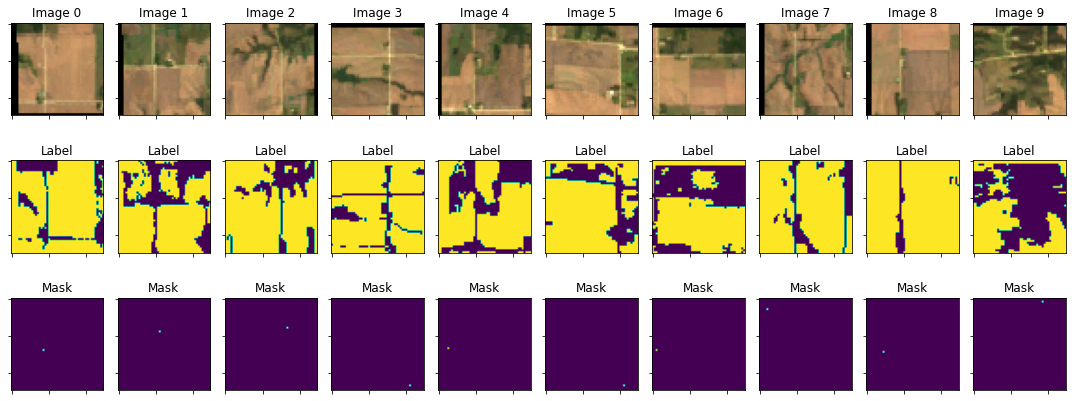

In [6]:
# getting an image batch
samples = next(iter(dataloaders['train']))

# printing batch size
print("Image batch size: ", samples[1].shape[0])

# plotting figures
rcParams['figure.figsize'] = 15, 6
fig, ax = plt.subplots(3, 10)
for i in range(0, 10):
    
  im = transforms.ToPILImage()(samples[0][i, 1:4 :, :])
  B, G, R = im.split()
  im = Image.merge('RGB', (R.point(lambda i: i * 5), G.point(lambda i: i * 5), B.point(lambda i: i * 5)))
  width, height = im.size
  label = transforms.ToPILImage()(samples[1][i, :, :])
  mask = transforms.ToPILImage()(samples[2][i, :, :])

  ax[0, i].set_title('Image '+str(i))
  ax[0, i].imshow(im); ax[0, i].set_yticklabels([]); ax[0, i].set_xticklabels([]);
  ax[1, i].set_title('Label')
  ax[1, i].imshow(label); ax[1, i].set_yticklabels([]); ax[1, i].set_xticklabels([]);
  ax[2, i].set_title('Mask')
  ax[2, i].imshow(mask); ax[2, i].set_yticklabels([]); ax[2, i].set_xticklabels([]);

fig.tight_layout()

### Model and Training

We may then load the model. The network used by the authors for this task is described bellow:

<div align="center">
<img style="max-width: 80%; height: auto;" src="Figures/arch_1.png">
<figcaption style="font-size: 12px;">U-Net variation for single-pixel pipeline.</figcaption>
</div>

This network is a type of U-Net, with two down-convolutional blocks and two up-convolutional blocks is shown here. A block is comprised of two convolutional-batch norm layers followed by a max pool or up-convolutional layer. A masking is used at the loss computation step to train a U-Net on single pixel labels. Note that this network is configured to be a classification network, since it will only classify a single pixel. The network is shown bellow: 

In [7]:
# setting up cuda for usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# loading the model from a separate file
model = UNet(in_channels=7, out_channels=1, 
             starting_filters=params['starting_filters'], 
             bn_momentum=params['bn_momentum'])
model = model.cuda()

# visualizing the model
model

UNet(
  (conv1): downconv(
    (conv): conv_conv(
      (conv): Sequential(
        (0): Conv2d(7, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): downconv(
    (conv): conv_conv(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

The loss used in this pipeline is the BCE with logits, which is basicaly a Cross Entropy loss, followed by a BCE Loss, which measures the Binary Cross Entropy loss between target and output probabilities.

This network works by masking every pixel around the desired pixel and calculating the loss for a single pixel. Then, it will backpropagate only this pixel loss for the rest of the network. After trained, the activations of the last concolutional layer, that is, the "conv_out" layer seem above, will activate for the desired class for every pixel, and thus it can be used as a semantic segmentation output. The loss is shown bellow:

<div align="center">
<img style="max-width: 50%; height: auto;" src="Figures/loss_1.png">
<figcaption style="font-size: 12px;">Loss for a single pixel.</figcaption>
</div>

In this loss, the only labeled pixel is represented by $(j^*, k^*)$

As for the network optimization, the chosen optmizer is Adam, and a learning rate scheduler is also set to decay with training.

In [8]:
# loss function
criterion = nn.BCEWithLogitsLoss()

# setting up optimizer for every parameter
optimizer = optim.Adam(model.parameters(), lr=params['lr'],
                       betas=(params['beta1'], params['beta2']), weight_decay=params['weight_decay'])

# setting up an exponential learning rate decay by a factor of gamma every X epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer,
                                       step_size=params['decay_steps'],
                                       gamma=params['gamma'])

Finally, we may train and save the model.

Obs: it may be required to train the model for a high number of epochs in order to achieve a good performance. A total of 1000 epochs or even more is advised.

In [9]:
# model training
model, metrics = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, exp_lr_scheduler,
                             params, num_epochs=1000, gpu=args["gpu"])

# if desired to save the model
if params['save_model']:
    torch.save(model.state_dict(), os.path.join(args["model_dir"], 'best_model.pt'))

# the metrics are also stored
with open(os.path.join(args["model_dir"], 'metrics.json'), 'w') as f:
    json.dump(metrics, f)

C:\Users\jpklock\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 0/999
----------


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

### Results

And now we can try and classify an image.

In [ ]:
# samples from the validation dataset
samples = next(iter(dataloaders['val']))
inputs = samples[0].to(device)
labels = samples[1].to(device)
masks = samples[2].to(device)

# adjusting sizes
label_size = labels.shape[-1]
target_size = params["label_size"]
offset = (label_size - target_size)//2
labels = labels[:,offset:offset+target_size,offset:offset+target_size]
masks = masks[:,offset:offset+target_size,offset:offset+target_size]

# creating a sigmoid for prediction
s = nn.Sigmoid()

# getting model outputs and predictions
outputs = model(inputs)
outputs = outputs.squeeze()
preds = s(outputs) >= 0.5
preds = preds.float()

#outputs_masked = torch.masked_select(outputs, masks)
#labels_masked = torch.masked_select(labels, masks)
#preds_masked = torch.masked_select(preds, masks)

# getting batch size
print("Image batch size: ", samples[1].shape[0])

# plotting predictions
rcParams['figure.figsize'] = 20, 8
fig, ax = plt.subplots(4, 10)
for i in range(0, 10):

  im = transforms.ToPILImage()(samples[0][i, 1:4 :, :])
  B, G, R = im.split()
  im = Image.merge('RGB', (R.point(lambda i: i * 5), G.point(lambda i: i * 5), B.point(lambda i: i * 5)))
  width, height = im.size
  label = transforms.ToPILImage()(labels.cpu().numpy().astype(np.uint8)[i, :, :])
  mask = transforms.ToPILImage()(masks.cpu().numpy()[i, :, :])
  pred = transforms.ToPILImage()(preds.cpu().numpy().astype(np.uint8)[i, :, :])

  ax[0, i].set_title('Image '+str(i))
  ax[0, i].imshow(im); ax[0, i].set_yticklabels([]); ax[0, i].set_xticklabels([]);
  ax[1, i].set_title('Label')
  ax[1, i].imshow(label); ax[1, i].set_yticklabels([]); ax[1, i].set_xticklabels([]);
  ax[2, i].set_title('Mask')
  ax[2, i].imshow(mask); ax[2, i].set_yticklabels([]); ax[2, i].set_xticklabels([]);
  ax[3, i].set_title('Predicted')
  ax[3, i].imshow(pred); ax[3, i].set_yticklabels([]); ax[3, i].set_xticklabels([]);

fig.tight_layout()

## Second Experiment

For the next experiment, the images will be classified accordingly to only a single label, indicating whether the predominance of the image is a positive or negative example. In other words, it's "yes" or "no".

First we may go to the corresponding folder.

In [10]:
cd ../image_labels

C:\Users\jpklock\Desktop\seminario_weak\weakly_supervised\image_labels


Then we load the required libraries from separate files and the necessary parameters for the algrithm. Instead of pytorch, this pipeline uses tensorflow.

In [13]:
# loading libraries
from src.tfrecords import tfrecord_iterator
from src.UNet import build_UNet
from src.utils import Params, set_logger
from src.train_UNet import train_and_evaluate

# experiment parameters
args = {
    "model_dir": 'experiments', # model directory
    "data_dir": '../data', # data directory
    "restore_from": None # flag to restore previous results, not used here
}

# Load parameters from json file
json_path = os.path.join(args["model_dir"], 'params.json')
assert os.path.isfile(json_path), "No params.json configuration file found at {}".format(json_path)
params = Params(json_path)

# setting up logger
ts_uuid = f'{datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S%z")}_{uuid.uuid4().hex[:6]}'
log_dir = Path(args["model_dir"]) / 'logs'
log_dir.mkdir(exist_ok=True)
set_logger(str(log_dir / f'{ts_uuid}_train.log'))
logging.info("Creating the datasets from TFRecords...")

# obtaining the diretories with the data
data_dir = args["data_dir"]
data_folder = params.data_folder
train_file = os.path.join(data_dir, params.train_file)
val_file = os.path.join(data_dir, params.eval_file)
test_file = os.path.join(data_dir, params.test_file)

ModuleNotFoundError: No module named 'src.tfrecords'

Then we load the datasets.

In [14]:
# litst to store dataset
train_filenames = []
val_filenames = []
test_filenames = []

# opening dataset files
with open(train_file) as f:
    for l in f:
        train_filenames.append(os.path.join(data_dir, data_folder, l[:-1]))
with open(val_file) as f:
    for l in f:
        val_filenames.append(os.path.join(data_dir, data_folder, l[:-1]))
with open(test_file) as f:
    for l in f:
        test_filenames.append(os.path.join(data_dir, data_folder, l[:-1]))
        
# storing datasets sizes
params.train_size = len(train_filenames)
params.eval_size = len(val_filenames)
params.test_size = len(test_filenames)

# converting to a tensorflow iterator
train_dataset = tfrecord_iterator(True, train_filenames, params)
eval_dataset = tfrecord_iterator(False, val_filenames, params)
test_dataset = tfrecord_iterator(False, test_filenames, params)

NameError: name 'train_file' is not defined

### Dataset

We may now visualize the datasets. Unlike the previous dataset, this one is composed of only a single label indicating the presence of the class in the image or not.

In [15]:
# getting the dataset from tensorflow
with tf.Session() as sess:
  sess.run(train_dataset['iterator_init_op'])
  images, labels, seg_labels = sess.run([train_dataset["images"], train_dataset["labels"], train_dataset["seg_labels"]])

# printing batch size
print("Tamanho do batch de imagens: ", images.shape[0])

# plotting dataset
rcParams['figure.figsize'] = 15, 6
fig, ax = plt.subplots(3, 10)
for i in range(0, 10):

  im = transforms.ToPILImage()(np.transpose(images[i, :, :, 1:4]*255, (0, 1, 2)).astype(np.uint8))
  B, G, R = im.split()
  im = Image.merge('RGB', (R.point(lambda i: i * 2), G.point(lambda i: i * 2), B.point(lambda i: i * 2)))
  label = labels[i].astype(np.int)[0]
  mask = transforms.ToPILImage()(seg_labels[i, :, :]*255)

  ax[0, i].set_title('Image '+str(i))
  ax[0, i].imshow(im); ax[0, i].set_yticklabels([]); ax[0, i].set_xticklabels([]);
  ax[1, i].set_title('Label')
  ax[1, i].text(0.5, 0.5,str(label), horizontalalignment='center', verticalalignment='center'); ax[1, i].set_yticklabels([]); ax[1, i].set_xticklabels([]);
  ax[2, i].set_title('Mask')
  ax[2, i].imshow(mask); ax[2, i].set_yticklabels([]); ax[2, i].set_xticklabels([]);

fig.tight_layout()

NameError: name 'train_dataset' is not defined

### Model and Training

Next we define the model. Unlike the previous model, this one uses a class activation map (CAM), which is used to map which pixels activated the most. The network is described bellow:

<div align="center">
<img style="max-width: 70%; height: auto;" src="Figures/arch_2.png">
<figcaption style="font-size: 12px;">U-Net variation for image-level label pipeline.</figcaption>
</div>

(a) This network is composed of a combination of the U-Net and a class activation map (CAM) to create a new architecture for weakly supervised segmentation via image classification. (b) A CAM is obtained via a weighted sum across the filter dimension of the last convolutional layer output, where the weights come from the fully connected layer. The CAM is then thresholded to obtain a hard segmentation prediction.

Since this model performs a classification task, it is composed of a binary coss entropy loss.

<div align="center">
<img style="max-width: 50%; height: auto;" src="Figures/loss_2.png">
<figcaption style="font-size: 12px;">Binary Cross Entropy Loss.</figcaption>
</div>

Here, $y$ represents the binary label and $\hat{y}$ is the model prediction.

The model is loaded bellow.

In [16]:
# loading models for each dataset
logging.info("Creating the model...")
train_model = build_UNet('train', train_dataset, params)
eval_model = build_UNet('eval', eval_dataset, params, reuse=True)
test_model = build_UNet('eval', test_dataset, params, reuse=True)

train_model['cam']

NameError: name 'build_UNet' is not defined

Finally, the network will be trained and evaluated.

In [ ]:
# training network
logging.info("Starting training for {} epochs".format(params.num_epochs))
my_sess, train_metrics, eval_metrics, test_metrics, train_preds, eval_preds, test_preds = train_and_evaluate(train_model, eval_model, test_model, args["model_dir"], params, args["restore_from"], ts_uuid)

### Results

And then the model may be evaluated.

In [ ]:
# loading dataset for evaluation
with tf.Session() as sess:
  sess.run(test_dataset['iterator_init_op'])
  images, labels, seg_labels = sess.run([test_dataset["images"], test_dataset["labels"], test_dataset["seg_labels"]])

# printing the batch size
print("Image batch size: ", images.shape[0])

# plotting figures
rcParams['figure.figsize'] = 10, 8
fig, ax = plt.subplots(4, 5)
for i in range(0, 5):

  im = transforms.ToPILImage()(np.transpose(images[i, :, :, 1:4]*255, (0, 1, 2)).astype(np.uint8))
  B, G, R = im.split()
  im = Image.merge('RGB', (R.point(lambda i: i * 5), G.point(lambda i: i * 5), B.point(lambda i: i * 5)))
  label = labels[i].astype(np.int)[0]
  mask = transforms.ToPILImage()(seg_labels[i, :, :]*255)
  pred = transforms.ToPILImage()((test_preds[i, :, :]*255).astype(np.uint8))

  ax[0, i].set_title('Image '+str(i))
  ax[0, i].imshow(im); ax[0, i].set_yticklabels([]); ax[0, i].set_xticklabels([]);
  ax[1, i].set_title('Label')
  ax[1, i].text(0.5, 0.5,str(label), horizontalalignment='center', verticalalignment='center'); ax[1, i].set_yticklabels([]); ax[1, i].set_xticklabels([]);
  ax[2, i].set_title('Mask')
  ax[2, i].imshow(mask); ax[2, i].set_yticklabels([]); ax[2, i].set_xticklabels([]);
  ax[3, i].set_title('Prediction')
  ax[3, i].imshow(pred); ax[3, i].set_yticklabels([]); ax[3, i].set_xticklabels([]);

fig.tight_layout()

# Exercise

The rest of this notebook contains the exercise to be performed for this class. This exercise will be based in the paper:

### Unsupervised Learning of Image Segmentation Based on Differentiable Feature Clustering

Wonjik Kim*, Asako Kanezaki*, and Masayuki Tanaka. **Unsupervised Learning of Image Segmentation Based on Differentiable Feature Clustering**. IEEE Transactions on Image Processing, accepted, 2020.

This paper proposed an Unsupervised approach to performe image semantic segmentation, and the usage of weak labels to improve performance. It was chosen because of its simplicity and because it is easy to understand.

## Proposed Network

&emsp;We start by showing the proposed pipeline for this paper. The procedure starts with and input image $I$, and consists of using a simple network composed of a feature extraction block to extract features from the image. The feature etraction block has 3 components, each with a Convolutional Layer, a ReLU activation and a Batch Normalization. After extracting the features, a single classification layer containing $q$ classes will be trained, where $q$ is variable. The goal is to make the network learn which of the $q$ classes should be activated for each image, and the output are response vectors for each pixel in the $q$-dimensional cluster space. In order words, the network functions as a pixel clustering strategy. And since the network will learn the classes by itself, $q$ must be a high number, the authors use a value of $q = 100$, although in the figure a value of $q = 3$ is used.

&emsp;Afterwards, the response vectors are normalized across the axes of the cluster space through a batch normalization, creating the Normalized Response Maps. Then, in order to determine which is the cluster, or class, of a given pixel, a High-pass filter is used, which is an argmax function along the $q$ outputs for the pixel.

&emsp;For the loss, the clusters are then used as pseudo targets to compute the feature similarity loss, which is summed with the spatial continuity loss and backpropagated through the network.

&emsp;Aditionally to this pipeline, the authors propose the usage of a weak supervision strategy to improve the model performace, that is, the usage of scribbles as an additional network loss. The scribble loss will be further detailed.

$\;$

<div align="center">
<img style="max-width: 90%; height: auto;" src="Figures/arch_3.png">
<figcaption style="font-size: 12px;">Proposed pipeline.</figcaption>
</div>

$\;$

&emsp;The implementation in this notebook is based in the authors implementation, given in the link bellow:

[https://github.com/kanezaki/pytorch-unsupervised-segmentation](https://github.com/kanezaki/pytorch-unsupervised-segmentation)

Before starting, we may set the parameters.

In [20]:
# experiment parameters
args = {
    "nChannel": 10, # q value, or maximum number of clusters
    "maxIter": 2000, # iteration number
    "lr": 1e-3, # learning rate
}

### Network Model

The network model is given bellow, as described above:

In [21]:
# proposed network model for this work. The network hyperparameters have been parametrized
class MyNet(nn.Module):
    def __init__(self, convs, kern):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, args["nChannel"], kernel_size=kern, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(args["nChannel"])
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        self.convs = convs
        for i in range(convs-1):
            self.conv2.append( nn.Conv2d(args["nChannel"], args["nChannel"], kernel_size=kern, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(args["nChannel"]) )
        self.conv3 = nn.Conv2d(args["nChannel"], args["nChannel"], kernel_size=1, stride=1, padding=int((kern-3)*(convs/2)) )
        self.bn3 = nn.BatchNorm2d(args["nChannel"])

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(self.convs-1):
            x = self.conv2[i](x)
            x = F.relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

## Dataset

For this experiment, a dataset of 10 images from the region of São Carlos, obtained by a VANT will be used. 8 images will be used for training and 2 images will be used for testing.

In this work, the labels of the images will be scribbles, which are scratches indicating the class of the image. This is considered a weak label and it is easy to obtain. An example of scribbles is shown bellow:

<div align="center">
<img style="max-width: 100%; height: auto;" src="Figures/scribble.jpg">
<figcaption style="font-size: 12px;">Example of scribbles.</figcaption>
</div>

In order to read the data, an special class is constructed that will allow us to also manually label the dataset. This will be done using the "Canvas" library for python and notebook, which allow the user to interact with the notebook. We start by setting two global variables, one for storing the drawings and another for storing their colors.

In [22]:
# setting global variables
global shape2
global color2
shape2 = []
color2 = []

Afterwards, some functions will be defined. The first three functions define how the mouse position is stored when movimenting and clicking in the image.

In [23]:
# function when pressing the mouse button
def on_mouse_down(x, y):
    global drawing
    global position
    global shape

    drawing = True
    position = (x, y)
    shape = [position]

# function when moving the mouse
def on_mouse_move(x, y):
    global drawing
    global position
    global shape

    if not drawing:
        return

    with hold_canvas(canvas):
        canvas.stroke_line(position[0], position[1], x, y)

        position = (x, y)

    shape.append(position)

# function when letting the button go
def on_mouse_up(x, y):
    global drawing
    global position
    global shape

    drawing = False

    with hold_canvas(canvas):
        canvas.stroke_line(position[0], position[1], x, y)
        #canvas.fill_polygon(shape)

    shape2.append(shape)
    color2.append(canvas.stroke_style)
    shape = []

Then we define a function to interpolate a list of points and get the lines between them.

In [24]:
# function to interpolate points
def get_interpolation(points_list):

    # list to store points
    interp_points = []
    
    # this function receives a list of sets of points
    for i in range(0, len(points_list)):
        
        # get the current set of points
        points = np.array(points_list[i])
        
        # discard small lists that cannot be interpolated
        if len(points) < 3:
            continue
        
        # get the unique list of points and discards repeated points
        # (they mess up the interpolation)
        indexes = np.unique(points, return_index=True, axis=0)[1]
        points = [points[index] for index in sorted(indexes)]

        # get the linear length along the lines
        distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
        distance = np.insert(distance, 0, 0)/distance[-1]

        # define a temporary variable for the interpolation
        alpha = np.linspace(0, 1, 1000)
        # create a cubic interpolator
        interpolator =  interp1d(distance, points, kind='cubic', axis=0)
        # interpolate the points
        interpolated_points = interpolator(alpha)
        
        # then we round the points (since they represent pixel positions)
        # and get only the unique positions
        rd_points = np.round(interpolated_points)
        interp_points.append(np.unique(rd_points, axis=0).astype(np.int64))
        
    # return the interpolated points
    return interp_points

Next we need to define three functions that will be used in the dataset class. The first is a function to get the labels given a list of points, their colors and the previous label image.

In [25]:
# function to get label image
def get_labels(label, shape2, color2):
    
    # interpolate list of scribbles
    interp_points = get_interpolation(shape2)
    
    # convert label image for usage
    label = np.array(label).astype(np.float32)

    # iterate through the list of points
    for i in range(0, len(interp_points)):

        # convert the current color from HEX to RGB
        col = [int(color2[i][j+1:j+3], 16) for j in (0, 2, 4)]
        
        # place the color in the scribble points
        label[interp_points[i][:, 1], interp_points[i][:, 0], :] = col
        
    # return labels as uint8 image
    return label.astype(np.uint8)

The next function will be used to get a 1 channel version of the labels image, that is, it will convert the labels for a single image with classes in the place of pixels. This is required because the algorithm works this way.

In [26]:
# function to get 1 channel label image
def get_label_1c(label, label_1c):
    
    # convert to usable format
    label = np.array(label).astype(np.float32)
    
    # reshape to pixels tuples with 3 color channels
    label2 = label.reshape((label.shape[0]*label.shape[1], label.shape[2]))
    label_1c2 = label_1c.reshape((label_1c.shape[0]*label_1c.shape[1]))

    # get the unique tuples (colors)
    colors = np.unique(label2, axis=0)

    # iterate through the colors
    for i in range(0, colors.shape[0]):

        # if there is black, ignore, since black is the background
        if np.sum(colors[i, :]) == 0:
            continue

        # find the position of the 3 components of the color in the label image
        idx0 = np.where( label2[:, 0] == colors[ i, 0 ] )[ 0 ]
        idx1 = np.where( label2[:, 1] == colors[ i, 1 ] )[ 0 ]
        idx2 = np.where( label2[:, 2] == colors[ i, 2 ] )[ 0 ]

        # get the intersection values between the 3 searches, that is, the actual color indexes
        idx = list(set(idx0).intersection(idx1).intersection(idx2))

        # place label. The labels are multiples of 5 to be well spaced, but this can be adjusted
        label_1c2[idx] = (i+1)*5

    # return to original image shape
    label_1c2 = label_1c2.reshape((label_1c.shape[0], label_1c.shape[1]))
    
    # return as uint8
    return label_1c2.astype(np.uint8)

And the last function will draw a scribble in an image, given the label image and the actual used image.

In [27]:
# function to draw scribbles
def draw_scribble(image, label):

    # convert to usable format
    label = np.array(label).astype(np.float32)
    image = np.array(image).astype(np.float32)
    
    # reshape to pixels tuples with 3 color channels
    label2 = label.reshape((label.shape[0]*label.shape[1], label.shape[2]))
    image2 = image.reshape((image.shape[0]*image.shape[1], image.shape[2]))
    
    # get the unique tuples (colors)
    colors = np.unique(label2, axis=0)

    # iterate through the colors
    for i in range(0, colors.shape[0]):
        
        # if there is black, ignore, since black is the background
        if np.sum(colors[i, :]) == 0:
            continue
        
        # find the position of the 3 components of the color in the label image
        idx0 = np.where( label2[:, 0] == colors[ i, 0 ] )[ 0 ]
        idx1 = np.where( label2[:, 1] == colors[ i, 1 ] )[ 0 ]
        idx2 = np.where( label2[:, 2] == colors[ i, 2 ] )[ 0 ]
        
        # get the intersection values between the 3 searches, that is, the actual color indexes
        idx = list(set(idx0).intersection(idx1).intersection(idx2))

        # place colors in image in the same place as their location in the label image
        image2[idx, :] = colors[i, :]
        
    # return to original image shape
    image2 = image2.reshape((image.shape[0], image.shape[1], image.shape[2]))

    # return as uint8
    return image2.astype(np.uint8)

And then we may define the Dataset class for this exercise.

In [28]:
# defining dataset class
class SegmentationDataset(VisionDataset):

    # initializing variables
    def __init__(self,
                 root: str,
                 image_folder: str,
                 label_folder: str,
                 transforms: Optional[Callable] = None) -> None:

        super().__init__(root, transforms)
        
        # getting paths strings
        self.image_folder_path = Path(self.root) / image_folder
        self.label_folder_path = Path(self.root) / label_folder

        # read images folder
        self.image_names = sorted(self.image_folder_path.glob("*"))

        # set current image pointer to 0
        self.currImage = 0
        
        # create vector to store image names
        self.image_names = np.array(self.image_names)
        
        # create multiple lists to store the images, labels and used colors
        self.images = list()
        self.labels = list()
        self.labels_1c = list()
        self.existing_colors = list()
        
        # iterate through images
        for index in range(0, len(self.image_names)):
            
            # get current image
            image_file = self.image_names[index]

            # open image
            image = Image.open(image_file)
            
            # if desired, set a base width and resize images
            #basewidth = 500
            #wpercent = (basewidth / float(image.size[0]))
            #hsize = int((float(image.size[1]) * float(wpercent)))
            #image = image.resize((basewidth,hsize), Image.ANTIALIAS)

            # get label path from image path
            label_path = str(self.label_folder_path)+'\\'+str(image_file).split('\\')[2][:-4]+'_label.png'
            
            # check if label path exist
            if os.path.exists(label_path):
                
                # if exists, load label
                label = Image.open(label_path)
                
                # create dummy 1 channel label and fill
                label_1c = np.array(np.zeros((image.height, image.width))).astype(np.uint8)
                label_1c = get_label_1c(label, label_1c)

                # get existing colors in current label
                label2 = np.array(label).astype(np.int32)
                label2 = label2.reshape((label2.shape[0]*label2.shape[1], label2.shape[2]))
                colors = np.unique(label2, axis=0)
                
                # convert to hex and store in memory
                hex_colors = ['#%02x%02x%02x' % (col[0], col[1], col[2]) for col in colors]
                self.existing_colors.append(hex_colors)

            # if label does not exist
            else:
                
                # create empty label image and 1 channel
                label = Image.fromarray(np.array(np.zeros((image.height, image.width, 3))).astype(np.uint8))
                label_1c = np.array(np.zeros((image.height, image.width))).astype(np.uint8)

            # store image, label and 1 channel label in memory
            self.images.append(image)
            self.labels.append(label)
            self.labels_1c.append(label_1c)
            
        # convert the list of lists of the existing color into a single vector
        self.existing_colors = [item for sublist in self.existing_colors for item in sublist]
        
        # get only the unique value among labels
        self.existing_colors = np.unique(self.existing_colors)
        
        # search for black color in list and exclude
        idx0 = np.where(self.existing_colors == '#000000')[0]
        if len(idx0) > 0:
            self.existing_colors = np.delete(self.existing_colors, idx0[0])
        
        # create dummy dropdown object to store colors. This is only a placeholder and not used
        self.drop = widgets.Dropdown(options=self.existing_colors,
                                    description='')
    
    # function to get length of dataset
    def __len__(self) -> int:
        return len(self.image_names)

    # function to get an item from the dataset
    def __getitem__(self, index: int) -> Any:
        
        # get current image and labels given the index
        image = self.images[index]
        label = self.labels[index]
        label_1c = self.labels_1c[index]
        
        # create output object to store images and labels
        sample = {"image": image, "label": label, "label_1c": label_1c, "index": index}
        
        # if a transformation is required (such as resize, normalization, etc) apply to the three images
        if self.transforms:
            sample["image"] = self.transforms(sample["image"])
            sample["label"] = self.transforms(sample["label"])
            sample["label_1c"] = self.transforms(sample["label_1c"])
             
        # return sample
        return sample
        
    # next we will define the function to label the dataset
    # this function is defined inside the class to use the properties of the dataset
    def labelDataset(self) -> Any:
        
        # load global variables in this scope
        global color2
        global shape2

        # get current image and convert to array
        image = self.images[self.currImage]
        npimage = np.array(image)
        
        # get image sizes
        width = image.width
        height = image.height

        # create a canvas object where the images will be shown
        canvas = RoughCanvas(width=width, height=height, sync_image_data=True)

        # create variables to store the information from the mouse, used in the mouse functions
        drawing = False
        position = None
        shape = []

        # link mouse functions defined previously to canvas
        canvas.on_mouse_down(on_mouse_down)
        canvas.on_mouse_move(on_mouse_move)
        canvas.on_mouse_up(on_mouse_up)
        
        # set initial color as red
        canvas.stroke_style = "#ff0000"

        # create a color picker to choose the class colors
        picker = ColorPicker(description="Color:", value="#ff0000")

        # link the color from the color picker to the canvas color (useful for changing the color later)
        link((picker, "value"), (canvas, "stroke_style"))

        # insert labels in current image
        npimage = draw_scribble(npimage, self.labels[self.currImage])
        
        # place current image in canvas
        canvas.put_image_data(npimage, 0, 0)

        # we now define a function to change the image in display
        def change_image(currImage):
            
            # declare global variables in this scope
            global shape2
            global color2

            # check if anything was drawn
            if len(shape2) > 0:
                
                # if so, get drawn labels and insert in label image
                self.labels[self.currImage] = get_labels(self.labels[self.currImage], shape2, color2)
                # also update the 1 channel label image
                self.labels_1c[self.currImage] = get_label_1c(self.labels[self.currImage], self.labels_1c[self.currImage])
            
            # convert label image to usable format
            label2 = np.array(self.labels[self.currImage]).astype(np.int32)
            
            # reshape for pixels as tuples with channels
            label2 = label2.reshape((label2.shape[0]*label2.shape[1], label2.shape[2]))
            
            # get colors
            colors = np.unique(label2, axis=0)
            
            # convert colors to HEX
            hex_colors = ['#%02x%02x%02x' % (col[0], col[1], col[2]) for col in colors]

            # insert colors in memory
            self.existing_colors = np.append(self.existing_colors, hex_colors)

            # get unique colors
            self.existing_colors = np.unique(self.existing_colors)
            
            # check for black color and delete if found
            idx0 = np.where(self.existing_colors == '#000000')[0]
            if len(idx0) > 0:
                self.existing_colors = np.delete(self.existing_colors, idx0[0])

            # update dummy dropdown with colors
            self.drop.options = self.existing_colors
            
            # update current image as the next image
            self.currImage = currImage
            
            # get new image
            image = self.images[currImage]
            
            # draw labels in new image
            new_image = draw_scribble(image, self.labels[self.currImage])
            
            # reset scribbles and colors global variables
            shape2 = []
            color2 = []
            
            # place new image in canvas
            canvas.put_image_data(new_image, 0, 0)
        
        # create a dropdown to select the image to draw the scribbles
        # also creates a button to save the current image data and change the image (for the image selected in the dropdown)
        manu = widgets.interactive(change_image, {'manual': True}, currImage = widgets.Dropdown(
                                    options=range(0, len(self.images)),
                                    description='Image Nº:'))

        # renaming button
        manu.children[1].description = 'Save Label/Select Image'
        
        # and now we create a function to save the current image label (scribbles) to memory
        def save_label():
            
            # get current image number
            currImage = self.currImage
            # get current label
            currLabel = np.array(self.labels[currImage]).astype(np.uint8)
            # create image object
            currLabel = Image.fromarray(currLabel)
            # get image name
            currName = self.image_names[currImage]
            # save label image to labels folder
            currLabel = currLabel.save(str(self.label_folder_path)+"\\"+str(currName)[:-4].split('\\')[2]+"_label.png")
            # print message to conclude work
            print("Image saved to "+str(self.label_folder_path)+"\\"+str(currName)[:-4].split('\\')[2]+"_label.png!")
        
        # next we create a button to save the label image to memory
        savi = widgets.interactive(save_label, {'manual': True})
        # and change the button description
        savi.children[0].description = 'Save File'

        # and this function will save every image label to memory
        def save_all_labels():
            
            # iterate through labels
            for i in range(0, len(self.labels)):
                
                # get current image number
                currImage = i
                # get current label
                currLabel = np.array(self.labels[currImage]).astype(np.uint8)
                # create image object
                currLabel = Image.fromarray(currLabel)
                # get image name
                currName = self.image_names[currImage]
                # save label image to labels folder
                currLabel = currLabel.save(str(self.label_folder_path)+"\\"+str(currName)[:-4].split('\\')[2]+"_label.png")
        
            # print message to conclude work
            print("Images saved to "+str(self.label_folder_path)+" successfully!")
            
        # and we may also create a button to save all the label images to memory
        savi2 = widgets.interactive(save_all_labels, {'manual': True})
        # and change the button description
        savi2.children[0].description = 'Save All Files'
        
        # this function will only set the current color as the chosen color
        def select_colors(selected):
            canvas.stroke_style = selected
        
        # finally, we create a interactive dropdown to choose the color used for labeling among the previously used colors
        # this is interesting to keep label consistency among images
        col_sel = widgets.interactive(select_colors, {'manual': True}, selected = widgets.Dropdown(
                                    options=self.existing_colors,
                                    description='Saved Colors:'))
        # and change the button name
        col_sel.children[1].description = 'Select Color'

        # and we link this color dropdown to the dummy dropdown defined in the beggining
        # this is necessary because only widgets can be linked, and thus the list must be stored inside one
        widgets.link((col_sel.children[0], 'options'), (self.drop, 'options'))
        
        # return the canvas and widgets
        return canvas, picker, manu, savi, savi2, col_sel

&emsp;We may now load the dataset, given the proper parameters.

In [29]:
# create the training dataset
image_dataset = SegmentationDataset(root="Dataset",
                                    image_folder="Images",
                                    label_folder="Labels",
                                    transforms=transforms.Compose([transforms.ToTensor()]))

# show training dataset
image_dataset

C:\Users\jpklock\anaconda3\lib\site-packages\traitlets\traitlets.py:588: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


Dataset SegmentationDataset
    Number of datapoints: 10
    Root location: Dataset
    Compose(
    ToTensor()
)

### Labeling the Dataset!

Now we finally place our labels in the dataset. The interface bellow is composed of:

<ul>
    <li>An image, which can be drawn to obtain the labels</li>
    <li>A color picker for choosing the current color/label</li>
    <li>An image selector dropdown, to choose which image to use</li>
    <li>A button for saving the current image and changing for the dropdown selected image</li>
    <li>A button for saving the label image to the labels directory</li>
    <li>A button for saving the all label images to the labels directory</li>
    <li>A dropdown with the used colors so far, along with every color used to draw</li>
    <li>A button for selecting the color in the dropdown</li>
</ul>

#### How to use

In order to get your dataset, just draw scribbles in your desired class and save the image when done!

It is adviseable to keep consistency of the classes among images, that is, if you use a blue color for labeling the grass in an image, use the same color for the grass in the next image. This is why the colors are save, to keep consistency.

Don't rush your draw, otherwise the interface might not get your mouse positions properly. In other words, draw slowly if possible!

**Always remember to click the "Save Label/Select Image" button BEFORE clicking the "Save File" file button.** The "Save Label" button will store the scribbles to memory. The "Save File" button will load the scribbles from memory and save to file. You must always store them in the memory first, before saving the file to computer, otherwise only the previous scribbles in memory will be saved to yout computer. You may click the "Save Label" button every few scribbles to keep checkpoints of your scribbles if you desire! This way, if you mess up a scribble, you will not lose the previous ones. To reload the image, just run the cell containing the canvas again.

It's recommended that you don't make too long lines, or the kernel might die due to some error. If a segment is too long, just break it in pieces, labeling a few parts every time.

### Exercise

1 - The fist exercise is to create your own labels for your dataset! Be creative and place as many scribbles as you want, always remembering to save the scribbles to memory and to save the files to your computer. Remember to keep consistency of the labels used, that is, use the same colors for the same classes in different images, such as red for every grass or blue to every forest and so on.

In [30]:
# getting canvas and widgets from the training dataset
canvas, picker, manu, savi, savi2, col_sel = image_dataset.labelDataset()

# creating a vertical array with the dropdowns and buttons
left_box = widgets.VBox([picker, manu, savi, savi2, col_sel])

# creating a horizontal array with the canvas and the widgets
HBox([canvas, left_box])

&emsp;Afterwards, we may place the created datasets in a dataloader object, to be used for training.

In [31]:
# create a training dataloader
image_dataloader = DataLoader(image_dataset, batch_size=1, shuffle=False, num_workers=0)

&emsp;And we may plot a sample from the dataset to check if everything is working properly.

Image batch size:  torch.Size([1, 3, 334, 500])
Label batch size:  torch.Size([1, 3, 334, 500])


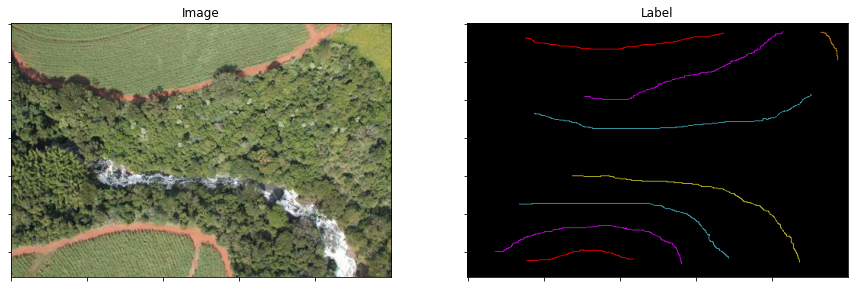

In [32]:
# get sample
samples = next(iter(image_dataloader))

# print image and label tensor shapes
print("Image batch size: ", samples['image'].shape)
print("Label batch size: ", samples['label'].shape)

# load image and label
im = transforms.ToPILImage()(samples['image'][0])
width, height = im.size
label = transforms.ToPILImage()(samples['label'][0])

# plot figures
rcParams['figure.figsize'] = 15, 15
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Image')
ax[0].imshow(im); ax[0].set_yticklabels([]); ax[0].set_xticklabels([]);
ax[1].set_title('Label')
ax[1].imshow(label); ax[1].set_yticklabels([]); ax[1].set_xticklabels([]);

## Network Losses

&emsp;There are two main losses in this pipeline, a feature similarity loss, and a spatial continuity loss. A third and optional loss may also be defined, which is the scribble loss. The loss are given bellow:

<div align="center">
<img style="max-width: 50%; height: auto;" src="Figures/losses.png">
<figcaption style="font-size: 12px;">Example of scribbles.</figcaption>
</div>

The feature similarity loss is given by applying an argmax function to the normalized response map $\{r^´_n\}$ in order to obtain the cluster labels $\{c_n\}$. These cluster labels will then be used as pseudo targets and the cross entropy loss between them is calculated. The purpose of this loss is to enhance the similarity between the features, that is, feature vectors from the same cluster will be similar.

<div align="center">
<img style="max-width: 50%; height: auto;" src="Figures/loss_spat.png">
<figcaption style="font-size: 12px;">Example of scribbles.</figcaption>
</div>

The spatial continuity loss is calculated by calculating the L1-norm of the horizontal and vertical differences of the response map $\{r^´_n\}$. This can be implemented through a differential operator, by taking the difference of the image both horizontally and vertically by shifting one pixel. The intuition behind this loss is that in image segmentation, it is preferable for clusters of pixels to be spatially continuous, and thus this image difference will suppress complicated patterns or textures.

<div align="center">
<img style="max-width: 50%; height: auto;" src="Figures/loss_cont.png">
<figcaption style="font-size: 12px;">Example of scribbles.</figcaption>
</div>

Finally, the scribble loss is used as a partial cross entropy loss, that is, since we know the class of the scribbles, we can classify the pixels corresponding to their locations normally.

<div align="center">
<img style="max-width: 50%; height: auto;" src="Figures/loss_scr.png">
<figcaption style="font-size: 12px;">Example of scribbles.</figcaption>
</div>

## Experiment

&emsp;In this exercise, the experiment to be performed will be a comparison between three different network trainings:

<ol>
    <li>Using the two originally proposed losses</li>
    <li>Using the two losses with the additional scribble loss</li>
    <li>Using only the scribble loss</li>
</ol>

After training, the images in the test dataset will be evaluated and compared, and you will describe their differences.

## Network Training

&emsp;First we may train the network. The network training goes as explained earlier while describing the network, and the corresponding losses are also calculated. In the loops bellow, three trainings will be performed, one for each case described above. The training is explained along the code.

In [ ]:
# flag to enable the network training
train_network = True 

# experiments
experiments = ["Original", "WithScribble", "OnlyScribble"]

# if it doesn't exist, create a models folder
if not os.path.exists('Models'):
    os.mkdir('Models')

if train_network:
    
    # iterating through experiments
    for expe in experiments:

        # print current experiment
        print('Current experiment: '+expe+'\n')

        # print start of the training
        print('Training started: '+str(datetime.datetime.now()))
        
        # start image counter
        imCounter = 0
        
        # iterate through the images
        for sample in tqdm(iter(image_dataloader), dynamic_ncols =True, desc='Images', leave=False):
            
            # load network model with 2 convolutional layers and 3x3 kernels (default)
            model = MyNet( 2, 3 )

            # set cuda use
            if use_cuda:
                model.cuda()

            # set model for training
            model.train()

            # feature similarity loss definition
            loss_fn = torch.nn.CrossEntropyLoss()

            # scribble loss definition
            loss_fn_scr = torch.nn.CrossEntropyLoss()

            # continuity losses definition
            loss_hpy = torch.nn.L1Loss(size_average = True)
            loss_hpz = torch.nn.L1Loss(size_average = True)

            # define adam optimizer
            optimizer = optim.Adam(model.parameters(), lr=args["lr"])
            
            # load current labels
            data = sample['image']
            label = sample['label_1c']

            # get image shapes
            shape0 = image_dataset[0]['image'].shape[1]
            shape1 = image_dataset[0]['image'].shape[2]

            # create differential losses variables
            HPy_target = torch.zeros(data.shape[0], shape0-1, shape1, args["nChannel"])
            HPz_target = torch.zeros(data.shape[0], shape0, shape1-1, args["nChannel"])
            if use_cuda:
                HPy_target = HPy_target.cuda()
                HPz_target = HPz_target.cuda()

            # fix mask shape for loss calculation
            mask = label.numpy()[:, 0, :, :]
            mask = mask.reshape(-1)
            # get unique labels
            mask_inds = np.unique(mask)
            # delete 0 as label
            mask_inds = np.delete( mask_inds, np.argwhere(mask_inds==0) )
            # get indexes of pixels with zero value
            inds_sim = torch.from_numpy( np.where( mask == 0 )[ 0 ] )
            # get indexes of pixels with a class (from scribble)
            inds_scr = torch.from_numpy( np.where( mask != 0 )[ 0 ] )
            # convert the whole mask to a variable
            target_scr = torch.from_numpy( mask.astype(np.int) )

            # convert variables to cuda
            if use_cuda:
                inds_sim = inds_sim.cuda()
                inds_scr = inds_scr.cuda()
                target_scr = target_scr.cuda()
                data = data.cuda()
            target_scr = Variable( target_scr ).cuda()
            data = Variable(data).cuda()
            
            # get the minimum number of labels for the image
            minLabels = len(mask_inds)
            
            # list to store losses
            losses = []
            
            # iterate through the number of iterations
            for batch_idx in trange(args["maxIter"], dynamic_ncols =True, desc='Iterations'):

                # empty the optimizer gradient 
                optimizer.zero_grad()

                # get output from model
                output = model( data )

                # remove a dimension from the data
                output = output.permute( 0, 2, 3, 1 ).contiguous().view( data.shape[0], -1, args["nChannel"] )

                # reshape output to calculate differences
                outputHP = output.reshape( (data.shape[0], shape0, shape1, args["nChannel"]) )

                # calculate shiffited image differences horizontally and vertically
                HPy = outputHP[:, 1:, :, :] - outputHP[:, 0:-1, :, :]
                HPz = outputHP[:, :, 1:, :] - outputHP[:, :, 0:-1, :]

                # calculate the spatial continuity losses
                lhpy = loss_hpy(HPy,HPy_target)
                lhpz = loss_hpz(HPz,HPz_target)

                # get the argmax from the model output using the shape of the image
                ignore, target = torch.max( output, 1 )
                im_target = target.data.cpu().numpy()
                nLabels = len(np.unique(im_target))

                # remove another dimension from the data, resulting in nBatch*Width*Heigth x q
                output = output.reshape( output.shape[0] * output.shape[1], -1 )

                # get the argmax from the model output in the q dimension
                # that is, find the cluster of each pixel
                ignore, target = torch.max( output, 1 )

                # 1. calculate the feature similarity loss between the obtained outputs and the pixels with value zero
                # or, outputs that we have no information of
                if expe == 'Original':
                    loss =  1 * loss_fn(output[ inds_sim ], target[ inds_sim ]) + \
                        1 * (lhpy + lhpz)
                # 2. calculate the scribble loss between output and pixels with scribble classification
                elif expe == 'WithScribble':
                    loss =  1 * loss_fn(output[ inds_sim ], target[ inds_sim ]) + \
                        0.5 * loss_fn_scr(output[ inds_scr ], target_scr[ inds_scr ].to(torch.long)) + \
                        1 * (lhpy + lhpz)
                # 3. sum with the spatial continuity loss
                elif expe == 'OnlyScribble':
                    loss =  0.5 * loss_fn_scr(output[ inds_scr ], target_scr[ inds_scr ].to(torch.long))

                # append losses to vector
                losses.append(loss.data.cpu().numpy())

                # propagate losses through network and step optimizer
                loss.backward()
                optimizer.step()
                
                if nLabels <= minLabels:
                    print ("nLabels", nLabels, "reached minLabels", minLabels, ".")
                    break

            # save network current state and delete previous file
            torch.save(model.state_dict(), 'Models\\model_'+expe+'_'+str(image_dataset.image_names[imCounter]).split('\\')[2][:-4]+'.pth')

            # salva final losses variable
            filehandler = open('losses_'+expe+'_'+str(image_dataset.image_names[imCounter]).split('\\')[2][:-4]+'.pickle', 'wb')
            pickle.dump(losses, filehandler)
            filehandler.close()
            
            # increase image counter
            imCounter += 1

        # print training end
        print('Training ended: '+str(datetime.datetime.now())+'\n')

Current experiment: Original

Training started: 2022-02-08 00:57:09.170349


Images:   0%|                                                                                   | 0/10 [00:00<…

C:\Users\jpklock\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
C:\Users\jpklock\AppData\Local\Temp/ipykernel_27516/3744421877.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  target_scr = torch.from_numpy( mask.astype(np.int) )


Iterations:   0%|                                                                             | 0/2000 [00:00<…

Iterations:   0%|                                                                             | 0/2000 [00:00<…

Iterations:   0%|                                                                             | 0/2000 [00:00<…

Iterations:   0%|                                                                             | 0/2000 [00:00<…

### Training Plot

&emsp;To check the model training, we may plot the losses through time.

In [ ]:
# open losses files and store losses
total_losses = []
for expe in experiments:
    for i in range(0, len(image_dataset.image_names)):
        with (open('losses_'+expe+'_'+str(image_dataset.image_names[i]).split('\\')[2][:-4]+'.pickle', "rb")) as openfile:
            losses = pickle.load(openfile)
            total_losses.append(losses)

# plotting figures
rcParams['figure.figsize'] = 20, 20
fig, ax = plt.subplots(len(image_dataset.image_names), 3)
for i in range(0, len(image_dataset.image_names)):
    ax[i, 0].set_title(experiments[0]+'_'+str(image_dataset.image_names[i]).split('\\')[2][:-4])
    ax[i, 0].plot(np.array(total_losses[i])); ax[i, 0].set_ylabel('Loss'); ax[i, 0].set_xlabel('Image');
    ax[i, 1].set_title(experiments[0]+'_'+str(image_dataset.image_names[i]).split('\\')[2][:-4])
    ax[i, 1].plot(np.array(total_losses[i+len(image_dataset.image_names)])); ax[i, 1].set_ylabel('Loss'); ax[i, 1].set_xlabel('Image');
    ax[i, 2].set_title(experiments[0]+'_'+str(image_dataset.image_names[i]).split('\\')[2][:-4])
    ax[i, 2].plot(np.array(total_losses[i+2*len(image_dataset.image_names)])); ax[i, 2].set_ylabel('Loss'); ax[i, 2].set_xlabel('Image');

## Results

&emsp;After training, we may see the results for each network in the two images of the test dataset. In order to visualize the results, the pixels of each class will be assigned the mean of every pixel of the given class. This way, a forest with mostly green pixels will look green. The loop for loading the models and saving the images is given bellow.

In [ ]:
# flag to get results
get_results = True

if get_results:
    
    # # experiments
    experiments = ["Original", "WithScribble", "OnlyScribble"]

    # iterate through the experiments
    for expe in experiments:

        # print current experiment
        print('Current experiment: '+expe+'\n')
        
        # initiate image counter
        imCounter = 0
        
        # path for storing results
        modelPath = 'Results\\Model_' + expe

        # create results folder
        if not os.path.exists(modelPath):
            os.mkdir(modelPath)

        # print testing start
        print('Testing '+str(len(image_dataset.image_names))+' images: '+str(datetime.datetime.now()))
        
        # create an iterator for the image dataloader
        ds_iter = iter(image_dataloader)
        
        # iterate through test dataset
        for samp in trange(len(image_dataset.image_names), dynamic_ncols=True, desc='Images'):

            # create instance of the network
            model = MyNet( 2, 3 )

            # load model for current experiment
            model.load_state_dict(torch.load('Models\\model_'+expe+'_'+str(image_dataset.image_names[imCounter]).split('\\')[2][:-4]+'.pth'))
            
            # enable cuda
            if use_cuda:
                model.cuda()
            model.eval() # configura rede para teste
            
            # get current sample
            sample = next(ds_iter)

            # load image and convert to numpy array
            data = sample['image']
            currIm = np.array(transforms.ToPILImage()(data[0]))

            # enable cuda
            if use_cuda:
                data = data.cuda()
            data = Variable(data).cuda()

            # get model output for image
            output = model( data )

            # change output shape
            output = output.permute( 0, 2, 3, 1 ).contiguous().view( data.shape[0], -1, args["nChannel"] )
            output = output.reshape( output.shape[0] * output.shape[1], -1 )

            # get activations for each cluster
            ignore, target = torch.max( output, 1 )
            # convert to numpy and reshape
            inds = target.data.cpu().numpy().reshape( (data.shape[2], data.shape[3]) )

            # create 2 temporary vectors with the same size as used by the network
            # one with pixels equal to 1
            # another with 1 tuples
            listTemp = []
            inds_rgb = []
            for i in range(data.shape[2]*data.shape[3]):
                listTemp.append([1])
                inds_rgb.append([1, 1, 1])
            listTemp = np.array(listTemp)
            inds_rgb = np.array(inds_rgb)

            # normalize image
            imOri = currIm/255
            # get current mask
            currMask = inds
            # repeate the mask for 3 dimensions
            currMask = np.repeat(currMask[:, :, np.newaxis], 3, axis=2)
            # remove one dimension
            res_labels = currMask.reshape(-1, currMask.shape[2])
            res_im = imOri.reshape(-1, imOri.shape[2])
            # get the unique labels in the output
            u_labels = np.unique(res_labels, axis=0)
            # create 3 temporary lists
            l_inds = [] # list for storing the index of each class
            im_means = [] # list for storing the mean color of the pixels
            im_sizes = [] # list for storing the number of pixels in each class
            
            # iterate through the unique classes
            for j in range(len(u_labels)):

                #find position of each color component in every pixel
                idx0 = np.where( res_labels[:, 0] == u_labels[ j, 0 ] )[ 0 ]
                idx1 = np.where( res_labels[:, 1] == u_labels[ j, 1 ] )[ 0 ]
                idx2 = np.where( res_labels[:, 2] == u_labels[ j, 2 ] )[ 0 ]
                # get the intersection between the indexes to obtain the real indexes
                idx = list(set(idx0).intersection(idx1).intersection(idx2))

                # append indexes for the current color
                l_inds.append( idx )
                # get the mean color for the current class
                currColors = 255*np.mean(res_im[ idx ], axis=0)
                # save the normalized mean color
                im_means.append( list(np.mean(res_im[ idx ], axis=0)) )
                # save the number of pixels for this class
                im_sizes.append(len(idx))
                # change every element in the class for their class number
                listTemp[ idx ] = [j+1]
                # change pixels by their mean color
                inds_rgb[ idx ] = [currColors[0], currColors[1], currColors[2]]

            # reshape for the final desired shape
            # listTemp is the 1 channel mask, with each pixel containing their class value
            # inds_rgb contains the image with each pixel colored by the mean color of its class
            listTemp = np.array(listTemp.reshape(currMask.shape[0], currMask.shape[1]), dtype=np.int64)
            inds_rgb = np.array(inds_rgb.reshape(currMask.shape[0], currMask.shape[1], 3), dtype=np.uint8)

            # save the labels present in the current image
            uni_labels = np.array(np.unique(listTemp), dtype=np.int64)

            # change color order to save image using opencv
            inds_rgb = cv2.cvtColor(inds_rgb, cv2.COLOR_RGB2BGR)

            # save image
            cv2.imwrite( os.path.join(modelPath, str(image_dataset.image_names[imCounter]).split('\\')[2][:-4] + '.png'), inds_rgb )
            imCounter += 1
                
        print('Testing ended: '+str(datetime.datetime.now())+'\n')

### Visualizing Results

&emsp;At last, we may visualize the results for each dataset.

In [ ]:
# searching results and storing images
ims = []
masks = []
for expe in experiments:
    for i in range(0, len(image_dataset.image_names)):
        im = Image.open(str(image_dataset.image_names[i]))
        ims.append(im)
        mask = Image.open("Results\\Model_"+expe+"\\"+str(image_dataset.image_names[i]).split('\\')[2][:-4] + '.png')
        masks.append(mask)

#plotting figures
rcParams['figure.figsize'] = 20, 20
fig, ax = plt.subplots(len(image_dataset.image_names), 4)
ax[0, 0].set_title('Original Image')
ax[0, 0].imshow(ims[0]); ax[0, 0].set_yticklabels([]); ax[0, 0].set_xticklabels([]);
ax[1, 0].set_title('Original Image')
ax[1, 0].imshow(ims[1]); ax[1, 0].set_yticklabels([]); ax[1, 0].set_xticklabels([]);
for i in range(0, len(image_dataset.image_names)):
    ax[i, 0].set_title('Original Image')
    ax[i, 0].imshow(ims[i]); ax[i, 0].set_yticklabels([]); ax[i, 0].set_xticklabels([]);
    ax[i, 1].set_title(experiments[0]+' Result')
    ax[i, 1].imshow(masks[i]); ax[i, 1].set_yticklabels([]); ax[i, 1].set_xticklabels([]);
    ax[i, 2].set_title(experiments[1]+' Result')
    ax[i, 2].imshow(masks[i+len(image_dataset.image_names)]); ax[i, 2].set_yticklabels([]); ax[i, 2].set_xticklabels([]);
    ax[i, 3].set_title(experiments[2]+' Result')
    ax[i, 3].imshow(masks[i+2*len(image_dataset.image_names)]); ax[i, 3].set_yticklabels([]); ax[i, 3].set_xticklabels([]);

## Exercise:

&emsp;After seeing the results, it is clear that using only the Scribble loss does not lead to good results, but using it combined with the other losses actually increase the unsupervised results performance. Now, answer the questions:

Question 1: What do you think are the main advantages of the weakly supervised approach?

R:

Question 2: How did the model benefit from the scribble loss?

R:

Question 3: What do you think could be made to increase the model performance?

R: